In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import requests

In [22]:

params1 = {
    "type": "data",
    "subject": "science",
    "grade": "8",
    "subscale": "SRPUV", 
    "variable": "CENSREG",
    "jurisdiction": "NP", 
    "stattype": "MN:MN", 

}

# api endpoint
url = "https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx"

response = requests.get(url, params=params1)


In [29]:
years = [2009, 2011, 2015, 2019, 2024]

dff = []

for year in years:
    params = params1.copy()
    params["year"] = year
    
    response = requests.get(url, params=params)
    # check request and flatten json
    if response.status_code == 200:
        result_json = response.json()
        df = pd.json_normalize(result_json["result"])
        df["year"] = year
        dff.append(df)
        print(f"Data for {year} ({len(df)} rows)")
    else:
        print(f"{response.status_code} for {year}")

if dff:
    finaldf = pd.concat(dff, ignore_index=True)
    print(finaldf.shape)
    print(finaldf.head())
else:
    print("no data found")


Data for 2009 (4 rows)
Data for 2011 (4 rows)
Data for 2015 (4 rows)
Data for 2019 (4 rows)
Data for 2024 (4 rows)
(20, 18)
   year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  \
0  2009     R3            2009       2     Grade 8    MN:MN     SCI      8   
1  2009     R3            2009       2     Grade 8    MN:MN     SCI      8   
2  2009     R3            2009       2     Grade 8    MN:MN     SCI      8   
3  2009     R3            2009       2     Grade 8    MN:MN     SCI      8   
4  2011     R3            2011       2     Grade 8    MN:MN     SCI      8   

   scale jurisdiction       jurisLabel variable          variableLabel  \
0  SRPUV           NP  National public  CENSREG  Region of the country   
1  SRPUV           NP  National public  CENSREG  Region of the country   
2  SRPUV           NP  National public  CENSREG  Region of the country   
3  SRPUV           NP  National public  CENSREG  Region of the country   
4  SRPUV           NP  National publi

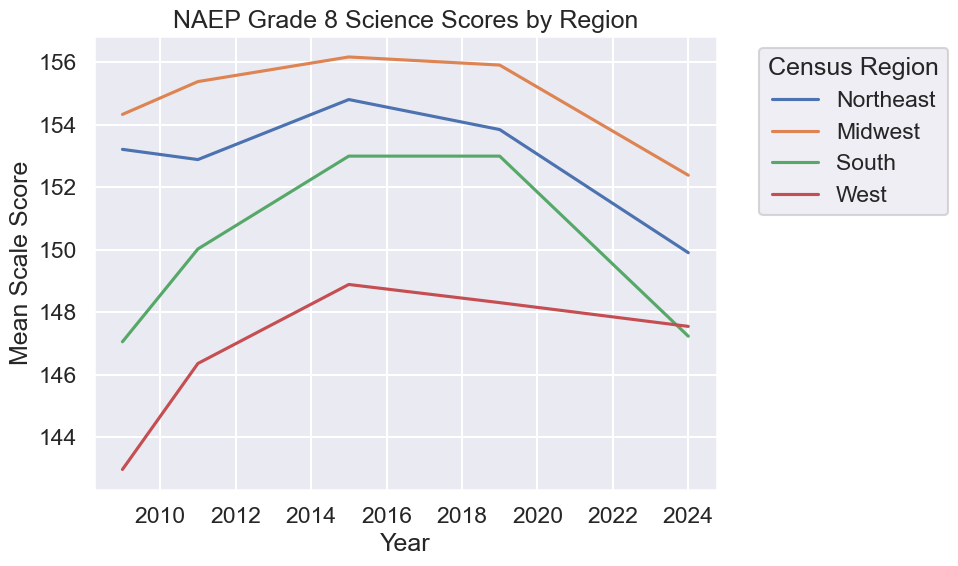

In [38]:
#sns.set( context="talk")

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=finaldf, x="year", y="value", hue="varValueLabel"
)

plt.title("NAEP Grade 8 Science Scores by Region")
plt.xlabel("Year")
plt.ylabel("Mean Scale Score")
plt.legend(title="Census Region", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
